## Introduction
This notebook contains an analysis of the images obtained from microscopic photographs of tissue samples into which boron has been injected and subsequently irradiated with thermal neutrons.

The objectives are to identify the grey value distribution of the background and to obtain information on the characteristics of the blobs associated with the neutron tracks. 
To perform said operation a preliminary analysis was need, in which by means of the software VGG we have manually selected all the visible track to the naked eye.
The selection operation consists of marking directly on the image with a circle the zone, the set of pixels, that we believe corresponds to a trace, the software automatically determines the diameter of the drawn circle and the position of its centre, as well as assigning a label to each selected region so that the information found can be neatly archived. As a result, we obtained a txt file for each image in which the coordinates (y, x, r) of each blob are marked.

These collected data will be used for the operations that will be performed here.

In [1]:
import os
import random

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from skimage import io

In [2]:
def upload_file(name_array: list, 
                folder: str):
    
    """This function upload all the files needed:
        - in image_array are stored all the images opened
        as a numpy array; image_array is an array of arrays.
        - in text_array are stored all the blobs' information 
        (coordinates and radius) for each image in the form of
        numpy array; text_array is an array of arrays.
        - lenght_array might be an useless variable, it contains 
        the lenght of every single array in text_array, that is 
        it helds the information about the number of blobs for 
        each image. Its scope is to aviod extra operations later.
    """
    image_array = []
    text_array = []
    lenght_array = []
    for name in name_array:
        img = io.imread(os.path.join("..", 
                                     "{}".format(folder),
                                     "{}.jpg".format(name)))
        image_array.append(img)
        if folder == "img":
            txt = np.loadtxt(os.path.join("..",
                                      "{}".format(folder),
                                      "{}_half.txt".format(name)))
            text_array.append(txt)
            lnght = len(txt)
            lenght_array.append(lnght)
        elif folder == "img_PseudoTracks":
            txt = np.loadtxt(os.path.join("..",
                                      "{}".format(folder),
                                      "{}.txt".format(name)))

            text_array.append(txt)
            lnght = len(txt)
            lenght_array.append(lnght)
            
    return image_array, text_array, lenght_array

def generate_mask(img: np.array, 
                  data: np.array):
    """This function generate a mask for every image in 
        which there is at least a single blob. The purpose
        of these masks is to locate the pixels that form the
        blobs and assign them the value True, while to the background 
        is assigned the False value.
        In the code is made the distiction between the case of single blob
        and multy blob image.
    """
    # mask size is the same as the image
    h, w = np.array(img).shape
    mask = np.zeros((h, w))
    color = 1
    if len(data) != 0:
        # there is the division between image with 
        # more than one blob and one blob due to 
        # how work numpy
        if not np.isscalar(data[0]):
            for blob in data:
                Y, X = np.ogrid[:h, :w]
                dist_from_center = np.sqrt((X - blob[1])**2 + (Y-blob[0])**2)
                mask[(dist_from_center <= blob[2]) == True ] = color
        else:
            Y, X = np.ogrid[:h, :w]
            dist_from_center = np.sqrt((X - data[1])**2 + (Y-data[0])**2)
            mask[(dist_from_center <= data[2]) == True ] = color
        
    return mask


def real_image_information(image_array: np.array,
                           track_array: np.array,
                           file: np.array,
                           image_name: list):
    """This is the main function.
        In the first part generate_mask is used to create said masks, 
        then they are superimpose on the respective images and the gray-level value
        of every pixel labeled as background is extracted in the variable
        all_background. After that, this variable is saved as a numpy array
        in order to be used in another program.
        In the second part some graphical analysis are performed, mainly we show 
        the distribution of gray-level value for the background pixels,
        of gray-level value for the (center) and radius of the blobs.
        Also the pyplot image with the istograms is saved in the png format.
    """
    
    masks = np.zeros((len(image_array), 1944, 2592))
    for i in range(len(image_array)):
        masks[i] = generate_mask(image_array[i], track_array[i])
    
    all_background = np.array([])
    for i in range(len(image_array)):
        dump = image_array[i][masks[i] < 1]
        all_background = np.concatenate((all_background, dump))
    np.save("real_back_color", all_background, allow_pickle=True)
    
    # this is the part with the code for plotting the histograms
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, figsize=(8, 6))
    fig.suptitle("True images information", y=1.05)
    
    ax1.hist(all_background, bins=74, range=(125, 200))
    ax1.axvline(np.median(all_background), color="black", linestyle="--", alpha=0.25)
    ax1.set_title("Distribution of background's grey level \n mean {:.2f} +- {:.2f}".format(
        np.median(all_background), all_background.std()), y=1.05)
    ax1.set_xlabel("Background's grey value")
    ax1.set_ylabel("Number of pixels")
    
    ax2.hist(file[:, 2], bins=10, range=(file[:, 2].min(), file[:, 2].max()))
    ax2.axvline(np.median(file[:, 2]), color="black", linestyle="--", alpha=0.25)
    ax2.set_title("Distribution of blobs' gray level \n mean {:.2f} +- {:.2f}".format(np.median(file[:, 2]), file[:, 2].std()))
    ax2.set_xlabel("Blob's grey value")
    ax2.set_ylabel("Number of blobs")
    
    ax3.hist(file[:, -1]/2, bins=7, range=(file[:, -1].min()/2, file[:, -1].max()/2))
    ax3.axvline(np.median(file[:, -1])/2, color="black", linestyle="--", alpha=0.25)
    ax3.set_title("Distribution of blobs' radius \n mean {:.2f} +- {:.2f}".format(np.median(file[:, -1])/2, (file[:, -1].std()/2)))
    ax3.set_xlabel("Blob's radius")
    ax3.set_ylabel("Number of blobs")
    
    plt.tight_layout()
    plt.savefig("Histogram_real_information.png", bbox_inches='tight')
    plt.show()
    plt.close()
    del all_background

def test_image_information(image_array: np.array,
                           track_array: np.array,
                           name_array: list):
    """The operation of this function is similar to the previous,
        but it analysed the artificially created images. These images
        are created by another program called Artifial_Images.
        Even in this case the distribution of the same values are plot
        through an histogram and saved as a png image, so that we can 
        compare the two distributions and see whether they have the same
        trend or not.
    """
    
    masks = np.zeros((len(image_array), 1944, 2592))
    for i in range(len(image_array)):
        masks[i] = generate_mask(image_array[i], track_array[i])
        #print("image {:03d}".format())
        
    all_background = np.array([])
    for i in range(len(image_array)):
        dump = image_array[i][masks[i] == False]
        all_background = np.concatenate((all_background, dump))
    
    blob_color = []
    for text in track_array:
        for row in text:
            blob_color.append(row[-1])

    blob_radius = []
    for text in track_array:
        for row in text:
            blob_radius.append(row[2])
            
    # plotting code  
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 6))
    fig.suptitle("Artificial images information", y=1.05)
    
    # background grey-level distribution plot
    ax1.hist(all_background, bins=74, range=(125, 200))
    ax1.axvline(np.median(all_background), color="black", linestyle="--", alpha=0.25)
    ax1.set_title("Distribution of background's grey level \n mean {:.2f} +- {:.2f}".format(
        np.median(all_background), all_background.std()), y=1.05)
    ax1.set_xlabel("Background's grey value")
    ax1.set_ylabel("Number of pixels")
    
    # blob grey-level distribution plot
    ax2.hist(blob_color, bins=10, range=(min(blob_color), max(blob_color)))
    ax2.axvline(np.median(blob_color), color="black", linestyle="--", alpha=0.25)
    ax2.set_title("Distribution of blobs' gray level \n mean {:.2f} +- {:.2f}".format(
        np.median(blob_color), np.std(blob_color)), y=1.05)
    ax2.set_xlabel("Blobs' grey value")
    ax2.set_ylabel("Number of blob")
    
    # blob radius distribution plot
    ax3.hist(blob_radius, bins=7, range=(min(blob_radius), max(blob_radius)))
    ax3.axvline(np.median(blob_radius), color="black", linestyle="--", alpha=0.25)
    ax3.set_title("Distribution of blobs' radius \n mean {:.2f} +- {:.2f}".format(
        np.median(blob_radius), np.std(blob_radius)), y=1.05)
    ax3.set_xlabel("Blobs' radius value")
    ax3.set_ylabel("Number of blob")
    
    # saving all three plots in an image
    plt.tight_layout()
    plt.savefig("Histogram_test_information.png", bbox_inches='tight')
    plt.show()
    plt.close()
    del all_background
    del blob_color
    del blob_radius

## Explanation of operations 
The images used in our analysis are numbered from 000 to 239, so a list of string (real_names) is prepared and it is used in the function "upload_file" in order to have all the arrays described in the function its self.

For the definition of the variable "imgej_data" is used a file .csv derived from the software Imagej; we used it to derive more accurate information about the structure of the blobs: first images were randomly selected, then in each of them a dozen blobs were measured, i.e. we more accurately calculated the radius and extrapolated the grey value of the central pixel, which is considered the grey value of the whole blob, although this is an approximation. So the information on the distribution of the grey value of the blobs and their radius is taken from this ".csv" file, here called "Results.csv".

Finally, the function "real_image_information" is called and are printed out all the graph previously described.

<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\119_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\200_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\201_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\202_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\203_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\204_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt: Empty input file: "..\img\205_half.txt"
  txt = np.loadtxt(os.path.join("..",
<ipython-input-2-668781a3807c>:24: UserWarning: loadtxt

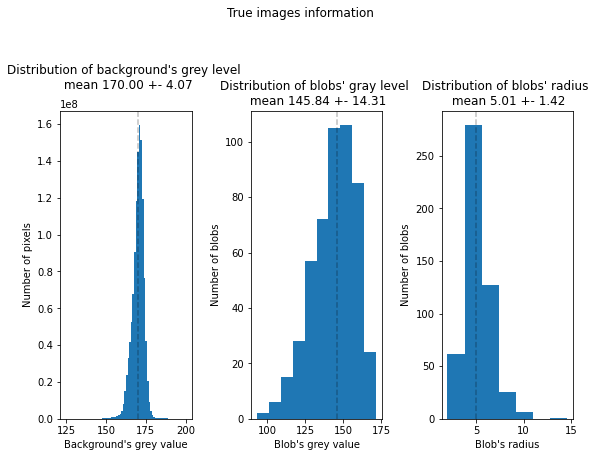

In [3]:
# the set of images used in our analysis are numbered
# from 000 to 239
real_names = ["{:03d}".format(i) for i in range(240)]
# in order are created the array of the images, the array of
# the text files, an array with the number of blob for every image
real_images, real_texts, real_lenghts = upload_file(real_names, 
                                                    "img")
# here the csv file from imageJ is upload
imagej_data = genfromtxt('Results.csv', delimiter=',', skip_header=1)

real_image_information(real_images,
                       real_texts,
                       imagej_data,
                       real_names)

## Explanation of operations
In the next cell, the same operations are carried out as in the previous one, but the artificial images are analysed to check that they have been created correctly.

In [ ]:
test_names = ["{:03d}".format(i) for i in range(1000)]
test_images, test_texts, test_lenghts = upload_file(test_names, 
                                                    "img_PseudoTracks")

test_image_information(test_images,
                       test_texts, 
                       test_names)

## The following cell is a simple check of the work
All previously created histograms are directly compared in order to verify that they have the same trend.

In [ ]:
real = io.imread("Histogram_real_information.png")
test = io.imread("Histogram_test_information.png")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.imshow(real)
ax1.set_axis_off()

ax2.imshow(test)
ax2.set_axis_off()

plt.show()
plt.close()

## The following cells are essentially useless
An histogram with the distribution of track numbers is plotted, it maight be an interest information

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.suptitle("Distribution of blobs' number,\n mean {:.2f} +- {:.2f}".format(
    np.median(real_lenghts), np.std(real_lenghts)))

ax.hist(real_lenghts, bins=60, range=(min(real_lenghts), max(real_lenghts)))
ax.axvline(np.median(real_lenghts), color="black", linestyle="--", alpha=0.25)

plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.suptitle("Distribution of blobs' number,\n mean {:.2f} +- {:.2f}".format(
    np.median(test_lenghts), np.std(test_lenghts)))

ax.hist(test_lenghts, bins=50, range=(min(test_lenghts), max(test_lenghts)))
ax.axvline(np.median(test_lenghts), color="black", linestyle="--", alpha=0.25)

plt.show()
plt.close()